# Clothes classification

https://cs231n.github.io/

## Tensorflow & Keras

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras
TF_ENABLE_ONEDNN_OPTS=0

2023-11-07 18:35:25.659549: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
from tensorflow.keras.preprocessing.image import load_img

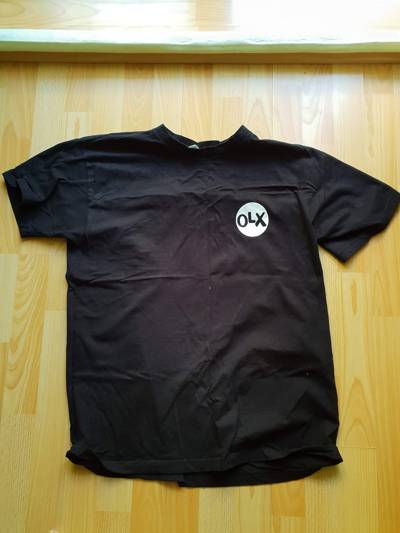

In [4]:
path = "./clothing-dataset-small/train/t-shirt/"
name = "5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg"
fullname = f'{path}/{name}'
load_img(fullname)

Neural networks are looking for to have the same size for the image to classify. 

In [5]:
# changing size
img = load_img(fullname, target_size=(299,299))

In [6]:
x = np.array(img)
x.shape

(299, 299, 3)

## Pre-trained Convolutional Neural Networks

In [7]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [8]:
model = Xception(weights="imagenet", input_shape=(299, 299, 3))

2023-11-07 18:35:27.683561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-07 18:35:27.690749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-07 18:35:27.691358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-07 18:35:27.692256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [9]:
X  = np.array([x])

In [10]:
X = preprocess_input(X)

In [11]:
pred = model.predict(X)

2023-11-07 18:35:31.073441: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-11-07 18:35:31.741478: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-07 18:35:31.742333: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-07 18:35:31.742375: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-11-07 18:35:31.743255: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-07 18:35:31.743336: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 3s 3s/step


In [12]:
decode_predictions(pred)

[[('n03595614', 'jersey', 0.6792451),
  ('n02916936', 'bulletproof_vest', 0.03960026),
  ('n04370456', 'sweatshirt', 0.035299566),
  ('n03710637', 'maillot', 0.010884127),
  ('n04525038', 'velvet', 0.0018057587)]]

This model doesn't seem to be right for our purpose. We're going to train another in order to classify clothes of our dataset and give recommendations to our customer.

## Convolutional Neural Networks

Two types of layers : 
- Convolutional & filters -> comparison between filters and part of the image
- Dense -> from vectors representation to prediction

## Transfer Learning

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(150, 150),
    batch_size=32
)

Found 3068 images belonging to 10 classes.


In [15]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [16]:
X, y = next(train_ds)

In [17]:
y[:5]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [18]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 341 images belonging to 10 classes.


In [19]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vectors)

model = keras.Model(inputs, outputs)

In [20]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

In [21]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [22]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 17s 145ms/step - loss: 1.3626 - accuracy: 0.6584 - val_loss: 0.9402 - val_accuracy: 0.7683
Epoch 2/10
96/96 [==============================] - 12s 124ms/step - loss: 0.6060 - accuracy: 0.8207 - val_loss: 1.1073 - val_accuracy: 0.7097
Epoch 3/10
96/96 [==============================] - 12s 124ms/step - loss: 0.3323 - accuracy: 0.8895 - val_loss: 0.8031 - val_accuracy: 0.7947
Epoch 4/10
96/96 [==============================] - 12s 122ms/step - loss: 0.2401 - accuracy: 0.9153 - val_loss: 0.9700 - val_accuracy: 0.7771
Epoch 5/10
96/96 [==============================] - 12s 122ms/step - loss: 0.2278 - accuracy: 0.9224 - val_loss: 0.8611 - val_accuracy: 0.7830
Epoch 6/10
96/96 [==============================] - 12s 123ms/step - loss: 0.2094 - accuracy: 0.9309 - val_loss: 0.9956 - val_accuracy: 0.7830
Epoch 7/10
96/96 [==============================] - 12s 121ms/step - loss: 0.0973 - accuracy: 0.9671 - val_loss: 0.8961 - val_accuracy: 0.8211

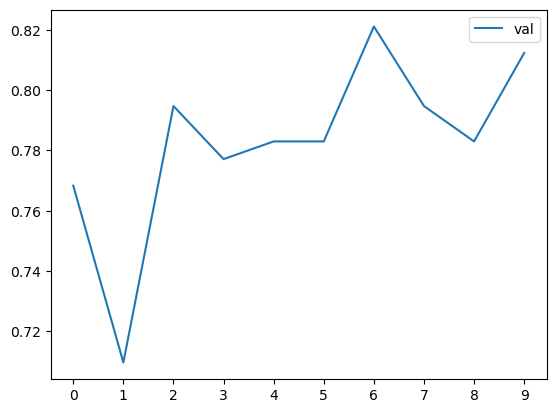

In [23]:
#plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

## Adjusting the learning rate

In [24]:
def make_model(learning_rate=0.01):
    base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
    )

    base_model.trainable = False
    
    #####################################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vectors)
    model = keras.Model(inputs, outputs)
    
    #####################################################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [25]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    
    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history
    
    print()
    print()

0.0001
Epoch 1/10
96/96 [==============================] - 15s 132ms/step - loss: 1.9995 - accuracy: 0.3008 - val_loss: 1.6580 - val_accuracy: 0.4780
Epoch 2/10
96/96 [==============================] - 12s 123ms/step - loss: 1.4118 - accuracy: 0.5587 - val_loss: 1.2843 - val_accuracy: 0.6217
Epoch 3/10
96/96 [==============================] - 12s 122ms/step - loss: 1.1512 - accuracy: 0.6392 - val_loss: 1.0910 - val_accuracy: 0.7067
Epoch 4/10
96/96 [==============================] - 12s 123ms/step - loss: 1.0061 - accuracy: 0.6894 - val_loss: 0.9753 - val_accuracy: 0.7390
Epoch 5/10
96/96 [==============================] - 12s 124ms/step - loss: 0.9113 - accuracy: 0.7148 - val_loss: 0.9027 - val_accuracy: 0.7595
Epoch 6/10
96/96 [==============================] - 12s 122ms/step - loss: 0.8424 - accuracy: 0.7301 - val_loss: 0.8453 - val_accuracy: 0.7537
Epoch 7/10
96/96 [==============================] - 12s 122ms/step - loss: 0.7890 - accuracy: 0.7500 - val_loss: 0.8082 - val_accuracy:

In [26]:
del scores[0.1]
del scores[0.0001]

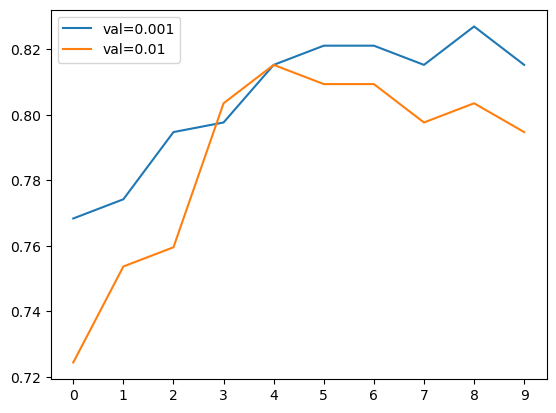

In [27]:
for lr, hist in scores.items():
    # plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [28]:
learning_rate = 0.001

## Checkpointing

In [29]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

In [30]:
learning_rate = 0.001

model = make_model(learning_rate=learning_rate)
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[checkpoint]
)

Epoch 1/10
96/96 [==============================] - 15s 134ms/step - loss: 1.1251 - accuracy: 0.6261 - val_loss: 0.7058 - val_accuracy: 0.7830
Epoch 2/10
96/96 [==============================] - 12s 126ms/step - loss: 0.6437 - accuracy: 0.7806 - val_loss: 0.6359 - val_accuracy: 0.7918
Epoch 3/10
96/96 [==============================] - 12s 125ms/step - loss: 0.5143 - accuracy: 0.8289 - val_loss: 0.5896 - val_accuracy: 0.8123
Epoch 4/10
96/96 [==============================] - 12s 127ms/step - loss: 0.4384 - accuracy: 0.8576 - val_loss: 0.5656 - val_accuracy: 0.8152
Epoch 5/10
96/96 [==============================] - 12s 125ms/step - loss: 0.3777 - accuracy: 0.8817 - val_loss: 0.5363 - val_accuracy: 0.8123
Epoch 6/10
96/96 [==============================] - 12s 128ms/step - loss: 0.3304 - accuracy: 0.9042 - val_loss: 0.5247 - val_accuracy: 0.8416
Epoch 7/10
96/96 [==============================] - 12s 123ms/step - loss: 0.2968 - accuracy: 0.9182 - val_loss: 0.5421 - val_accuracy: 0.8240

## Adding More Layers

In [31]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
    )

    base_model.trainable = False
    
    #####################################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation="relu")(vectors)
    
    outputs = keras.layers.Dense(10)(inner)
    model = keras.Model(inputs, outputs)
    
    #####################################################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [32]:
learning_rate = 0.001

scores = {}

for size in [10, 100, 1000]:
    print(size)
    
    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history
    
    print()
    print()

10
Epoch 1/10
96/96 [==============================] - 15s 133ms/step - loss: 1.8127 - accuracy: 0.2803 - val_loss: 1.4281 - val_accuracy: 0.5718
Epoch 2/10
96/96 [==============================] - 12s 123ms/step - loss: 1.2084 - accuracy: 0.6082 - val_loss: 0.9911 - val_accuracy: 0.7009
Epoch 3/10
96/96 [==============================] - 12s 124ms/step - loss: 0.8963 - accuracy: 0.7112 - val_loss: 0.7805 - val_accuracy: 0.7595
Epoch 4/10
96/96 [==============================] - 12s 124ms/step - loss: 0.7189 - accuracy: 0.7640 - val_loss: 0.7026 - val_accuracy: 0.7889
Epoch 5/10
96/96 [==============================] - 12s 124ms/step - loss: 0.6186 - accuracy: 0.7947 - val_loss: 0.6793 - val_accuracy: 0.7859
Epoch 6/10
96/96 [==============================] - 12s 121ms/step - loss: 0.5572 - accuracy: 0.8162 - val_loss: 0.6841 - val_accuracy: 0.7859
Epoch 7/10
96/96 [==============================] - 12s 123ms/step - loss: 0.5016 - accuracy: 0.8406 - val_loss: 0.6442 - val_accuracy: 0.7

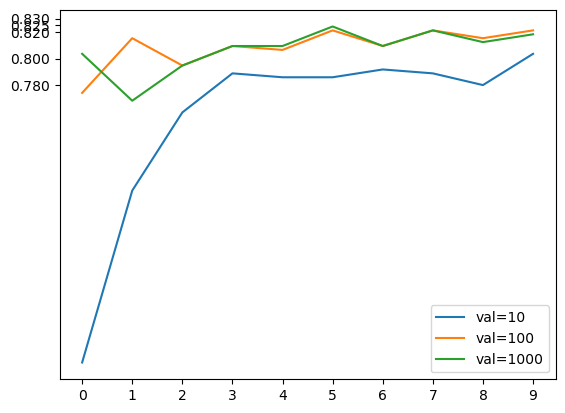

In [33]:
for size, hist in scores.items():
    # plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.yticks([0.78, 0.80, 0.82, 0.825, 0.83])
plt.legend()

## Regularization & Dropout

In [34]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
    )

    base_model.trainable = False
    
    #####################################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation="relu")(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(10)(drop)
    model = keras.Model(inputs, outputs)
    
    #####################################################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [35]:
learning_rate = 0.001
size = 100

scores = {}

for drop in [0, 0.2, 0.5, 0.8]:
    print(drop)
    
    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=drop)
    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    scores[drop] = history.history
    
    print()
    print()

0
Epoch 1/30
96/96 [==============================] - 15s 130ms/step - loss: 0.9598 - accuracy: 0.6734 - val_loss: 0.7252 - val_accuracy: 0.7507
Epoch 2/30
96/96 [==============================] - 12s 124ms/step - loss: 0.5072 - accuracy: 0.8269 - val_loss: 0.5581 - val_accuracy: 0.8211
Epoch 3/30
96/96 [==============================] - 12s 124ms/step - loss: 0.3532 - accuracy: 0.8836 - val_loss: 0.5481 - val_accuracy: 0.8006
Epoch 4/30
96/96 [==============================] - 12s 123ms/step - loss: 0.2554 - accuracy: 0.9234 - val_loss: 0.5404 - val_accuracy: 0.8152
Epoch 5/30
96/96 [==============================] - 12s 122ms/step - loss: 0.1798 - accuracy: 0.9488 - val_loss: 0.6197 - val_accuracy: 0.8123
Epoch 6/30
96/96 [==============================] - 12s 124ms/step - loss: 0.1248 - accuracy: 0.9759 - val_loss: 0.6532 - val_accuracy: 0.8065
Epoch 7/30
96/96 [==============================] - 12s 122ms/step - loss: 0.0958 - accuracy: 0.9795 - val_loss: 0.5604 - val_accuracy: 0.80

Epoch 28/30
96/96 [==============================] - 12s 123ms/step - loss: 0.0274 - accuracy: 0.9919 - val_loss: 0.8114 - val_accuracy: 0.8065
Epoch 29/30
96/96 [==============================] - 12s 124ms/step - loss: 0.0302 - accuracy: 0.9912 - val_loss: 0.7444 - val_accuracy: 0.8211
Epoch 30/30
96/96 [==============================] - 12s 124ms/step - loss: 0.0276 - accuracy: 0.9919 - val_loss: 0.7558 - val_accuracy: 0.8035


0.5
Epoch 1/30
96/96 [==============================] - 15s 132ms/step - loss: 1.2443 - accuracy: 0.5828 - val_loss: 0.7510 - val_accuracy: 0.7537
Epoch 2/30
96/96 [==============================] - 12s 124ms/step - loss: 0.8114 - accuracy: 0.7112 - val_loss: 0.6370 - val_accuracy: 0.7742
Epoch 3/30
96/96 [==============================] - 12s 124ms/step - loss: 0.6806 - accuracy: 0.7562 - val_loss: 0.6121 - val_accuracy: 0.7859
Epoch 4/30
96/96 [==============================] - 12s 124ms/step - loss: 0.5996 - accuracy: 0.7898 - val_loss: 0.5587 - val_accurac

Epoch 25/30
96/96 [==============================] - 12s 124ms/step - loss: 0.7052 - accuracy: 0.7350 - val_loss: 0.6098 - val_accuracy: 0.7977
Epoch 26/30
96/96 [==============================] - 12s 124ms/step - loss: 0.7026 - accuracy: 0.7220 - val_loss: 0.5773 - val_accuracy: 0.8035
Epoch 27/30
96/96 [==============================] - 12s 124ms/step - loss: 0.6995 - accuracy: 0.7370 - val_loss: 0.5750 - val_accuracy: 0.7977
Epoch 28/30
96/96 [==============================] - 12s 124ms/step - loss: 0.6886 - accuracy: 0.7363 - val_loss: 0.5811 - val_accuracy: 0.8123
Epoch 29/30
96/96 [==============================] - 12s 124ms/step - loss: 0.6739 - accuracy: 0.7363 - val_loss: 0.6132 - val_accuracy: 0.7947
Epoch 30/30
96/96 [==============================] - 12s 126ms/step - loss: 0.6947 - accuracy: 0.7213 - val_loss: 0.6066 - val_accuracy: 0.8035




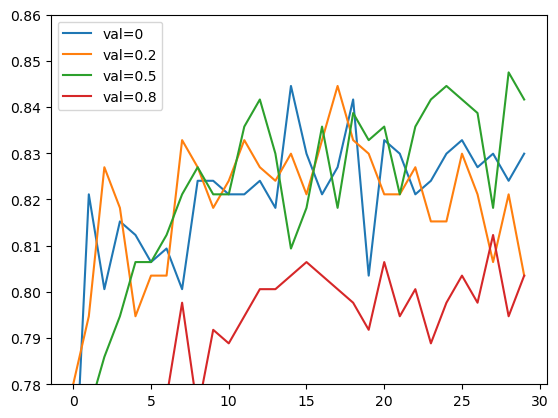

In [36]:
for drop, hist in scores.items():
    # plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % drop))
plt.ylim(0.78, 0.86)
plt.legend()

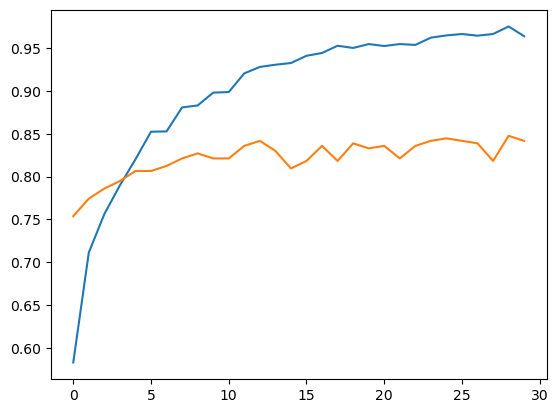

In [37]:
hist = scores[0.5]
plt.plot(hist['accuracy'], label=('train=%s' % drop))
plt.plot(hist['val_accuracy'], label=('val=%s' % drop))

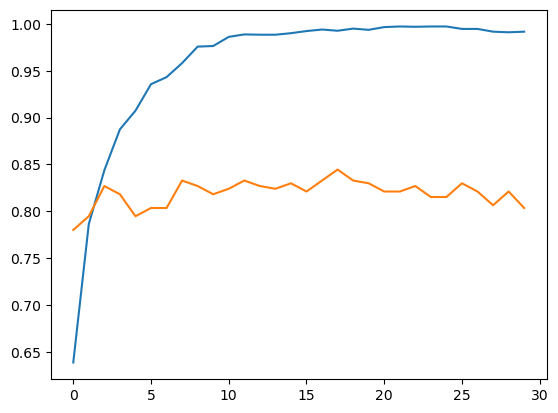

In [38]:
hist = scores[0.2]
plt.plot(hist['accuracy'], label=('train=%s' % drop))
plt.plot(hist['val_accuracy'], label=('val=%s' % drop))

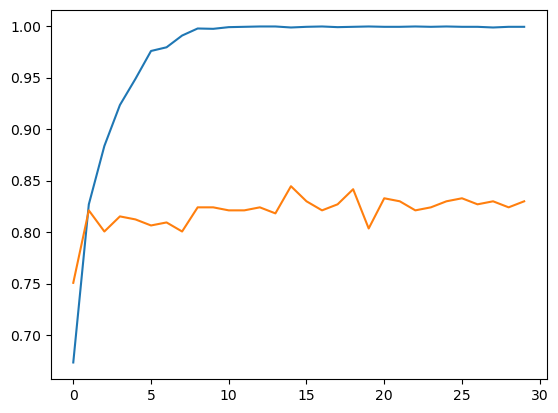

In [40]:
hist = scores[0.0]
plt.plot(hist['accuracy'], label=('train=%s' % drop))
plt.plot(hist['val_accuracy'], label=('val=%s' % drop))

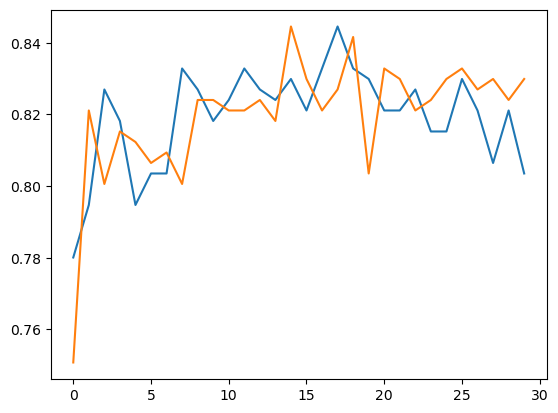

In [41]:
hist = scores[0.2]
plt.plot(hist['val_accuracy'], label=0.2)

hist = scores[0.0]
plt.plot(hist['val_accuracy'], label=0.0)

plt.legend()

## Data augmentation

In [42]:
train_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    shear_range=10.0,
    zoom_range=0.1,
    vertical_flip=True
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(150, 150),
    batch_size=32
)


val_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [43]:
learning_rate = 0.001
size = 100
drop = 0.2

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=drop)
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
96/96 [==============================] - 28s 264ms/step - loss: 1.3173 - accuracy: 0.5662 - val_loss: 0.7970 - val_accuracy: 0.7361
Epoch 2/50
96/96 [==============================] - 25s 255ms/step - loss: 0.9023 - accuracy: 0.6952 - val_loss: 0.7235 - val_accuracy: 0.7566
Epoch 3/50
96/96 [==============================] - 24s 252ms/step - loss: 0.7965 - accuracy: 0.7256 - val_loss: 0.6600 - val_accuracy: 0.7771
Epoch 4/50
96/96 [==============================] - 25s 255ms/step - loss: 0.7528 - accuracy: 0.7340 - val_loss: 0.6532 - val_accuracy: 0.7625
Epoch 5/50
96/96 [==============================] - 25s 256ms/step - loss: 0.6577 - accuracy: 0.7761 - val_loss: 0.6715 - val_accuracy: 0.7713
Epoch 6/50
96/96 [==============================] - 24s 253ms/step - loss: 0.6199 - accuracy: 0.7797 - val_loss: 0.6116 - val_accuracy: 0.7918
Epoch 7/50
96/96 [==============================] - 24s 253ms/step - loss: 0.5613 - accuracy: 0.7986 - val_loss: 0.6198 - val_accuracy: 0.8065

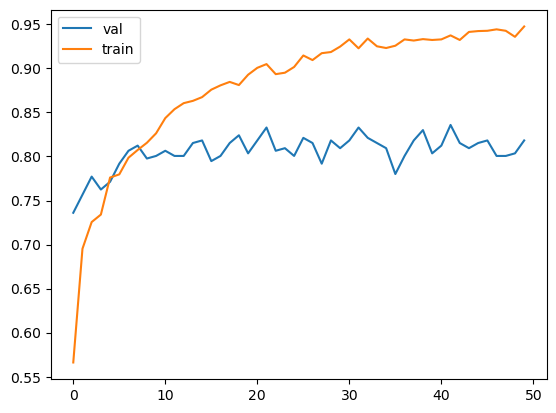

In [44]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')
plt.legend()

## Training a larger model

In [45]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False
    
    #####################################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation="relu")(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(10)(drop)
    model = keras.Model(inputs, outputs)
    
    #####################################################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [46]:
input_size = 299

In [47]:
train_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    shear_range = 10,
    zoom_range = 0.1,
    horizontal_flip = True
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(input_size, input_size),
    batch_size=32
)


val_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [48]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

In [50]:
learning_rate = 0.001
size = 100
drop = 0.2

model = make_model(
    input_size = input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=drop)
history = model.fit(train_ds, epochs=50, validation_data=val_ds,
                   callbacks=[checkpoint])

Epoch 1/50
96/96 [==============================] - 69s 686ms/step - loss: 0.8067 - accuracy: 0.7308 - val_loss: 0.7474 - val_accuracy: 0.7331
Epoch 2/50
96/96 [==============================] - 63s 659ms/step - loss: 0.4363 - accuracy: 0.8465 - val_loss: 0.7652 - val_accuracy: 0.7654
Epoch 3/50
96/96 [==============================] - 64s 662ms/step - loss: 0.3709 - accuracy: 0.8745 - val_loss: 0.6865 - val_accuracy: 0.7742
Epoch 4/50
96/96 [==============================] - 63s 659ms/step - loss: 0.3339 - accuracy: 0.8872 - val_loss: 0.7696 - val_accuracy: 0.7801
Epoch 5/50
96/96 [==============================] - 64s 660ms/step - loss: 0.2971 - accuracy: 0.8999 - val_loss: 0.6587 - val_accuracy: 0.7801
Epoch 6/50
96/96 [==============================] - 63s 649ms/step - loss: 0.2623 - accuracy: 0.9058 - val_loss: 0.7782 - val_accuracy: 0.7595
Epoch 7/50
96/96 [==============================] - 63s 650ms/step - loss: 0.2549 - accuracy: 0.9107 - val_loss: 0.7732 - val_accuracy: 0.7537

## Using the model

In [1]:
import tensorflow as tf
from tensorflow import keras

2023-11-07 20:37:51.149682: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
model = keras.models.load_model('xception_v4_15_0.792.h5')

2023-11-07 20:37:55.216553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-07 20:37:55.224062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-07 20:37:55.224683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-07 20:37:55.225616: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications.xception import preprocess_input

In [5]:
test_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

test_ds = test_gen.flow_from_directory(
    './clothing-dataset-small/test',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

Found 372 images belonging to 10 classes.


In [6]:
model.evaluate(test_ds)

2023-11-07 20:38:15.650903: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-11-07 20:38:16.298800: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-07 20:38:16.299710: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-07 20:38:16.299747: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-11-07 20:38:16.300621: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-07 20:38:16.300689: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


12/12 [==============================] - 7s 278ms/step - loss: 0.2539 - accuracy: 0.9086


[0.25391605496406555, 0.9086021780967712]

In [7]:
path = 'clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'

In [8]:
img = load_img(path, target_size=(299, 299))

In [9]:
import numpy as np

In [10]:
x = np.array(img)
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [11]:
X = preprocess_input(X)

In [12]:
pred = model.predict(X)

1/1 [==============================] - 1s 907ms/step


In [13]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

In [14]:
dict(zip(classes, pred[0]))

{'dress': -2.4819443,
 'hat': -4.268186,
 'longsleeve': -1.092416,
 'outwear': -3.5227954,
 'pants': 12.21088,
 'shirt': -0.70447695,
 'shoes': -5.946275,
 'shorts': 6.1732764,
 'skirt': -5.1205573,
 't-shirt': -3.6024354}